In [4]:
import pandas as pd
import yaml
from sklearn.metrics import ConfusionMatrixDisplay
root_path = '/local/work/merengelke/aipal/'
config = yaml.load(open('cfg.yaml', 'r'), Loader=yaml.FullLoader)

cities_countries = config['cities_countries']
paths = [f"{root_path}{city_country}/aipal/predict.csv" for city_country in cities_countries]

df = pd.DataFrame()
for path in paths:
    df_small = pd.read_csv(path)
    df_small['city_country'] = path.split('/')[-3]
    df = pd.concat([df, df_small])
    
# age over 18
if config['is_adult']:
    df = df[df['age'] > 18]
else:
    df = df[df['age'] <= 18]
df.drop(columns=['ELN', 'Diagnosis', 'additional.diagnosis.details..lineage.etc', 'lineage.details'], inplace=True)
df['class'].value_counts()

AML    752
APL    247
ALL    202
Name: class, dtype: int64

In [11]:
df.to_csv(("all_cohorts.csv"), index=False)

In [5]:
def prediction_data_pruner(df, threshold=0):
    """Remove data rows based on the threshold of missing values."""
    data = df
    mandatory_columns = ['Fibrinogen_g_L', 'LDH_UI_L', 'WBC_G_L', 'Lymphocytes_G_L',
    'MCHC_g_L', 'MCV_fL', 'Monocytes_G_L', 'Platelets_G_L',
    'PT_percent']
    
    ['MCV_fL', 'PT_percent', 'LDH_UI_L', 'MCHC_g_L', 'WBC_G_L', 'Fibrinogen_g_L', 'Monocytes_G_L', 'Platelets_G_L', 'Lymphocytes_G_L']

    data["nan_percentage"] = data[mandatory_columns].isna().mean(axis=1)

    # Prune data where the percentage of NaN values is above the threshold
    data = data[data["nan_percentage"] <= threshold]
    data.drop(columns=["nan_percentage"], inplace=True)
    return data


/tmp/ipykernel_2401833/3935863735.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=["nan_percentage"], inplace=True)


,ID,age,class,MCV_fL,PT_percent,LDH_UI_L,MCHC_g_L,WBC_G_L,Fibrinogen_g_L,Monocytes_G_L,Platelets_G_L,Lymphocytes_G_L,sex,Monocytes_percent,prediction.ALL,prediction.AML,prediction.APL,city_country,UPN,max_pred
1,MHH2,24.00000,AML,85.0,56.00000,183.0,32.0,18.20,436.0,1.27,311.0,2.55,Female,6.978022,0.374188,0.585135,0.040678,bochum,NaN,AML
2,MHH3,30.00000,ALL,83.0,70.00000,2018.0,33.0,59.00,NaN,0.00,51.0,2.95,Male,0.000000,0.600515,0.375619,0.023866,bochum,NaN,ALL
3,MHH4,40.00000,AML,108.0,116.00000,173.0,35.0,1.00,425.0,0.03,76.0,0.93,Female,3.000000,0.171153,0.817505,0.011342,bochum,NaN,AML
4,MHH5,49.00000,AML,91.0,62.70000,188.0,37.0,9.90,700.0,5.77,25.0,1.88,Male,58.282828,0.021195,0.959750,0.019054,bochum,NaN,AML
5,MHH6,46.00000,AML,81.0,62.40000,1173.0,33.0,42.00,700.0,1.26,86.0,0.42,Female,3.000000,0.594299,0.347099,0.058601,bochum,NaN,ALL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,ICH-161,62.71595,AML,94.5,89.43089,546.0,33.8,15.47,386.0,4.70,68.0,6.60,Female,30.381383,0.082915,0.912531,0.004553,milano,NaN,AML
131,ICH-164,79.34839,AML,90.8,70.51282,302.0,33.5,53.72,511.0,16.50,110.0,34.20,Female,30.714818,0.026821,0.968902,0.004277,milano,NaN,AML
132,ICH-166,72.00274,AML,107.4,82.70677,106.0,35.1,2.08,243.0,0.10,2.0,1.30,Male,4.807692,0.066396,0.926456,0.007148,milano,NaN,AML
133,ICH-168,81.01574,AML,106.6,76.92308,133.0,33.5,2.03,550.0,0.20,52.0,1.70,Male,9.852217,0.039871,0.955119,0.005009,milano,NaN,AML


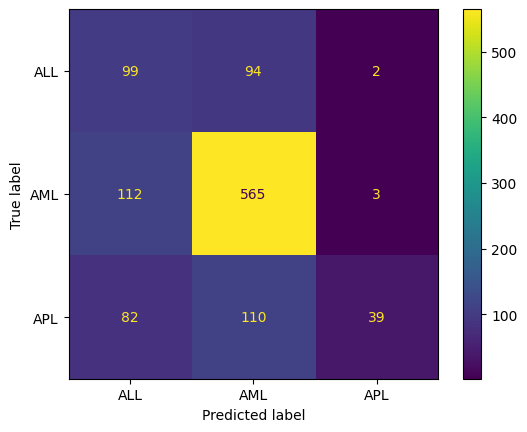

In [6]:
df[["prediction.ALL", "prediction.AML", "prediction.APL"]] = df[["prediction.ALL", "prediction.AML", "prediction.APL"]].astype(float)

df = prediction_data_pruner(df, threshold=0.2)

df["max_pred"] = df[["prediction.ALL", "prediction.AML", "prediction.APL"]].idxmax(axis=1)
df["max_pred"] = df["max_pred"].str.split(".").str[1]

ConfusionMatrixDisplay.from_predictions(df["class"], df["max_pred"])
df

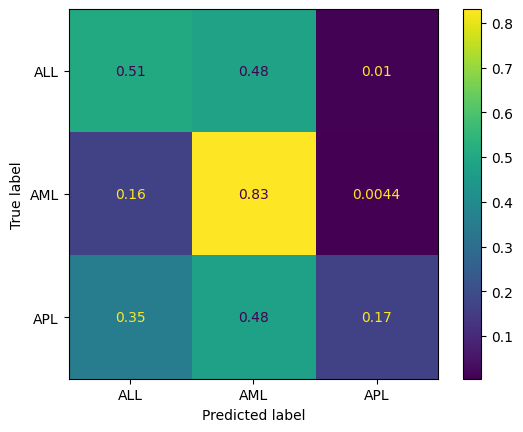

In [7]:
ConfusionMatrixDisplay.from_predictions(df["class"], df["max_pred"], normalize='true')

In [8]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import numpy as np

# Binarize the class labels
classes = df['max_pred'].unique()
y = label_binarize(df['class'], classes=classes)
n_classes = y.shape[1]

# Ensure the predictions are in the correct order
y_score = df[["prediction.ALL", "prediction.AML", "prediction.APL"]].values

# Calculate the AUC for each class
auc_scores = []
for i in range(n_classes):
    # Calculate AUC using true binary labels vs. prediction scores for class i
    auc_score = roc_auc_score(y[:, i], y_score[:, i])
    auc_scores.append(auc_score)
    print(f"AUC for {classes[i]}: {auc_score}")

# Calculate the average AUC
average_auc = np.mean(auc_scores)
print(f"Average AUC: {average_auc}")

AUC for AML: 0.28319870201601766
AUC for ALL: 0.2854682090686481
AUC for APL: 0.8542683982683983
Average AUC: 0.4743117697843547


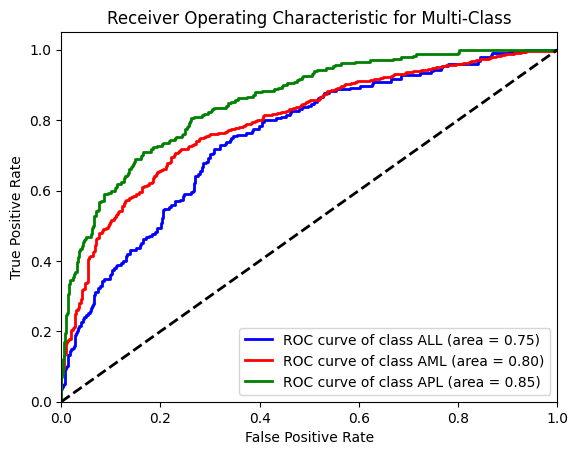

In [9]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Assuming df is your DataFrame and it has been processed as per your selection

# Binarize the class labels
# classes = df['max_pred'].unique()
classes = ["ALL", "AML", "APL"]
y = label_binarize(df['class'], classes=classes)
n_classes = y.shape[1]

# Convert predictions to a similar format for ROC calculation
y_score = df[["prediction.ALL", "prediction.AML", "prediction.APL"]].values

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()